# Develop adjoint LBVP - example

In [1]:
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import numpy as np

from scipy import optimize

logger = logging.getLogger(__name__)


# Parameters
Ny = 128
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ChebyshevT(coords['y'], size=Ny,dealias=1, bounds=(0, 2))

transform = ybasis.transform_plan(Ny)

y, = dist.local_grids(ybasis)

dy = lambda A: d3.Differentiate(A, coords['y'])

# Fields
u = dist.Field(name='u', bases=(ybasis))
v = dist.Field(name='v', bases=(ybasis))
w = dist.Field(name='w', bases=(ybasis))

gradu = dist.Field(name='gradu', bases=(ybasis))
gradv = dist.Field(name='gradv', bases=(ybasis))
gradw = dist.Field(name='gradw', bases=(ybasis))

U = dist.Field(name='U',bases=(ybasis))
U['g'] = y*(2-y)
Uy = dy(U)
alpha = -1
beta = 0
p = dist.Field(name='p', bases=(ybasis))
tau_u_1 = dist.Field(name='tau_u_1')
tau_u_2 = dist.Field(name='tau_u_2')

tau_v_1 = dist.Field(name='tau_v_1')
tau_v_2 = dist.Field(name='tau_v_2')

tau_w_1 = dist.Field(name='tau_w_1')
tau_w_2 = dist.Field(name='tau_w_2')

tau_p = dist.Field(name='tau_p')

ybasis2 = ybasis.derivative_basis(2)
transform2 = ybasis2.transform_plan(Ny)
# # Forcing
fu = dist.Field(name='fu',bases=(ybasis2))
fv = dist.Field(name='fv',bases=(ybasis2))
fw = dist.Field(name='fw',bases=(ybasis2))

# # Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
Re = 1000
omega = dist.Field(name='omega')
omega['g'] = 0.278
# # Problem
problem = d3.LBVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem.add_equation("1j*omega*u + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = fu")
problem.add_equation("1j*omega*v + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = fv")
problem.add_equation("1j*omega*w + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = fw")
problem.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem.add_equation("u(y=0) = 0")
problem.add_equation("u(y=2) = 0")

problem.add_equation("v(y=0) = 0")
problem.add_equation("v(y=2) = 0")

problem.add_equation("w(y=0) = 0")
problem.add_equation("w(y=2) = 0")

In [2]:
# Solver
solver = problem.build_solver()
# Check fu has the right bases to avoid convert
print(fu.domain.bases[0])
print(solver.F[0].domain.bases[0])

Jacobi(y, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)
Jacobi(y, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)


In [3]:
# Simple weight matrix using the Trapezium rule
# TODO: spectrally accurate weight matrix
def weightMatrixDisc():
    W = np.zeros(Ny)
    for i in range(Ny):
        if(i==0):
            W[i] = 0.5*(y[1]-y[0])
        elif(i==Ny-1):
            W[i] = 0.5*(y[Ny-1]-y[Ny-2])
        else:
            W[i] = 0.5*(y[i]-y[i-1]) + 0.5*(y[i+1]-y[i])
    return W
W = weightMatrixDisc()

In [4]:
def directAdjointLoopGrid(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    
    fu['g'] = forcing[:Ny]+1j*forcing[Ny:2*Ny]
    fv['g'] = forcing[2*Ny:3*Ny]+1j*forcing[3*Ny:4*Ny]
    fw['g'] = forcing[4*Ny:5*Ny]+1j*forcing[5*Ny:6*Ny]
    
    forcNorm = np.sum(np.conj(fu['g'].copy())*W*fu['g'].copy()).real
    forcNorm += np.sum(np.conj(fv['g'].copy())*W*fv['g'].copy()).real
    forcNorm += np.sum(np.conj(fw['g'].copy())*W*fw['g'].copy()).real
    fu['c']
    fv['c']
    fw['c']
    solver.solve()

    cost = np.sum(np.conj(solver.state[0]['g'])*W*solver.state[0]['g']).real
    cost += np.sum(np.conj(solver.state[1]['g'])*W*solver.state[1]['g']).real
    cost += np.sum(np.conj(solver.state[2]['g'])*W*solver.state[2]['g']).real

    cost = cost/forcNorm
    
    tmp0 = np.zeros(Ny,dtype=dtype) 
    tmp1 = np.zeros(Ny,dtype=dtype)
    tmp2 = np.zeros(Ny,dtype=dtype)
    
    v0 = W*u['g']/forcNorm
    v1 = W*v['g']/forcNorm
    v2 = W*w['g']/forcNorm
    
    transform.backward_adjoint(v0,tmp0,0)
    transform.backward_adjoint(v1,tmp1,0)
    transform.backward_adjoint(v2,tmp2,0)
        
    solver.state_adj[0]['c'] = tmp0
    solver.state_adj[1]['c'] = tmp1
    solver.state_adj[2]['c'] = tmp2
    
    solver.solve_adjoint()
    
    tmp0 = np.zeros(Ny,dtype=dtype) 
    tmp1 = np.zeros(Ny,dtype=dtype)
    tmp2 = np.zeros(Ny,dtype=dtype)
    
    v0 = solver.F_adj[0]['c'].copy()
    v1 = solver.F_adj[1]['c'].copy()
    v2 = solver.F_adj[2]['c'].copy()

    transform2.forward_adjoint(v0,tmp0,0)
    transform2.forward_adjoint(v1,tmp1,0)
    transform2.forward_adjoint(v2,tmp2,0)
    
    gradu['g'] = -cost/forcNorm*W*fu['g']  + tmp0
    gradv['g'] = -cost/forcNorm*W*fv['g']  + tmp1
    gradw['g'] = -cost/forcNorm*W*fw['g']  + tmp2

    graduDat = np.hstack((gradu['g'].real,gradu['g'].imag))
    gradvDat = np.hstack((gradv['g'].real,gradv['g'].imag))
    gradwDat = np.hstack((gradw['g'].real,gradw['g'].imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -grad

In [5]:
opts = {'disp': True}
forcing = np.random.rand(Ny*2*3)

sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True,options=opts)

2023-02-17 16:44:37,360 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s
2023-02-17 16:44:37,408 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16243D+01    |proj g|=  1.13337D+00

At iterate    1    f= -7.81169D+02    |proj g|=  9.51854D-01

At iterate    2    f= -8.58583D+02    |proj g|=  2.59590D-01

At iterate    3    f= -8.93132D+02    |proj g|=  1.24650D-01

At iterate    4    f= -9.06097D+02    |proj g|=  4.79183D-02

At iterate    5    f= -9.07155D+02    |proj g|=  2.76680D-02

At iterate    6    f= -9.07521D+02    |proj g|=  1.40693D-02

At iterate    7    f= -9.07615D+02    |proj g|=  8.04178D-03

At iterate    8    f= -9.07648D+02    |proj g|=  4.92812D-03

At iterate

 This problem is unconstrained.


Text(0.5, 1.0, 'Optimal response')

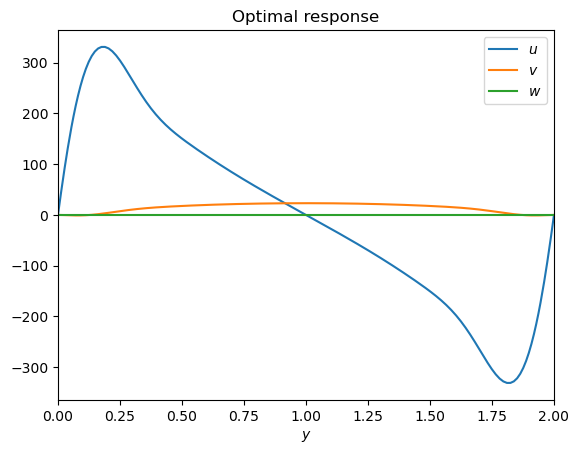

In [6]:
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal response')

Text(0.5, 1.0, 'Optimal forcing')

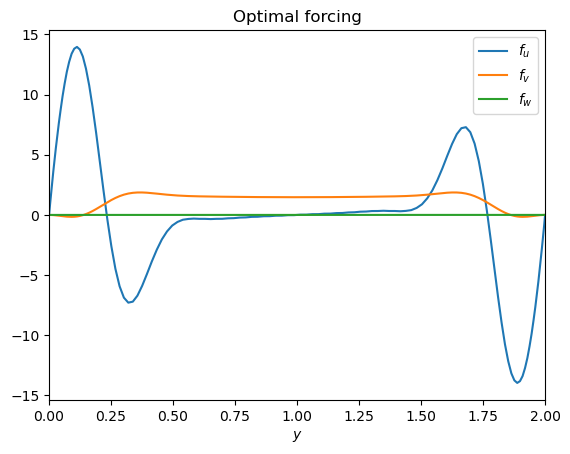

In [7]:
plt.plot(y,fu['g'].real,label=r'$f_u$')
plt.plot(y,fv['g'].real,label=r'$f_v$')
plt.plot(y,fw['g'].real,label=r'$f_w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal forcing')

In [8]:
%%time
omegas = np.linspace(0.1,1.5,120)
gains = []
for omega_v in omegas:
    omega['g'] = omega_v
    solver = problem.build_solver()
    sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True)
    gains.append(sol.fun)
gains = -np.array(gains)

2023-02-17 16:44:38,199 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-02-17 16:44:38,242 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:38,376 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-02-17 16:44:38,422 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-02-17 16:44:38,558 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-02-17 16:44:38,613 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-02-17 16:44:38,765 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:38,810 subsystems 0/1 INFO :: Building subproblem matrices 

2023-02-17 16:44:43,796 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-02-17 16:44:43,933 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:43,976 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:44,119 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:44,162 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:44,299 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-02-17 16:44:44,342 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-02-17 16:44:44,521 subsystems 0/1 INFO :: Building subproblem matrices 

2023-02-17 16:44:49,662 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:49,706 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:49,841 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:49,885 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:50,023 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:50,067 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:50,200 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-02-17 16:44:50,243 subsystems 0/1 INFO :: Building subproblem matrices 

2023-02-17 16:44:55,183 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-02-17 16:44:55,303 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:55,346 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-02-17 16:44:55,468 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:55,512 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:55,625 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-02-17 16:44:55,668 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-02-17 16:44:55,785 subsystems 0/1 INFO :: Building subproblem matrices 

(0.1, 1.5)

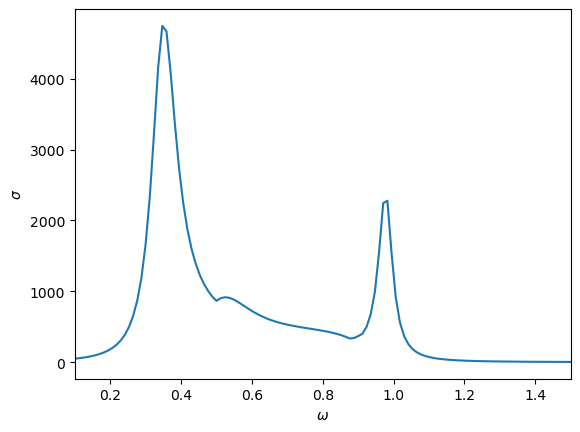

In [9]:
plt.plot(omegas,gains)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma$')
plt.xlim([omegas[0],omegas[-1]])